# Lab05 - Autoencoders for digit reconstruction

In this assignment we will build an autoencoder to that will reconstruct digits from in the MNIST datset.

In [22]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

from tqdm import tqdm

# import custom modules
from autoencoder_structure import Autoencoder
import testing_tools

### If cuda is available set the device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [23]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = MNIST('../datasets', train=True,  download=True, transform=train_transform)
test_dataset  = MNIST('../datasets', train=False, download=True, transform=test_transform)

# Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


Plot some sample from the dataset

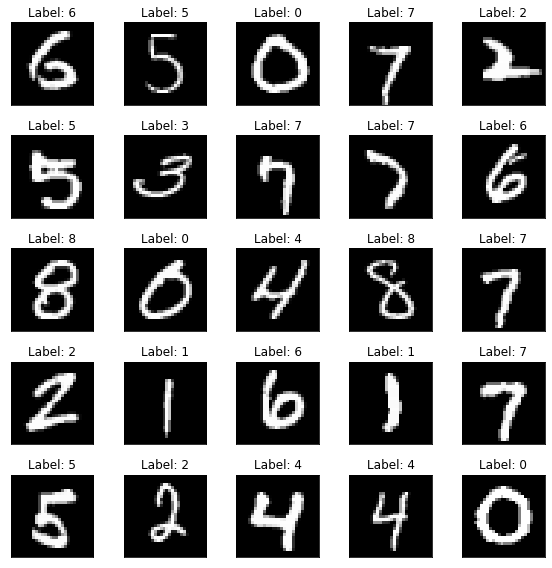

In [3]:
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Autoencoder class
### TO REMOVE

In [8]:
class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout=0):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.Dropout(dropout),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.Dropout(dropout),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    
    
    
    # -------- New functions ---------
    
    ### Function that perform an epoch of the training
    def train_epoch(self, dataloader, loss_fn, optimizer, log=True):
        
        # set training mode
        self.train()
        
        for sample_batch in dataloader:
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            output = self.forward(image_batch)
            loss = loss_fn(output, image_batch)
            # Backward pass
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # Print loss if requested
            if log:
                print('\t partial train loss: %f' % (loss.data))

         
        
    ### Testing function
    def test_epoch(self, dataloader, loss_fn, optimizer):
        
        # Validation
        self.eval() # Evaluation mode (e.g. disable dropout)
        
        with torch.no_grad(): # No need to track the gradients
            
            conc_out = torch.Tensor().float()
            conc_label = torch.Tensor().float()
            
            for sample_batch in dataloader:
                # Extract data and move tensors to the selected device
                image_batch = sample_batch[0].to(device)
                # Forward pass
                out = self.forward(image_batch)
                # Concatenate with previous outputs
                conc_out = torch.cat([conc_out, out.cpu()])
                conc_label = torch.cat([conc_label, image_batch.cpu()]) 
            
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
        
        return val_loss.data
    
    
    
    ### Function to get the encoded representation of an input dataset
    def get_enc_representation(dataset, net):
        encoded_samples = []

        for sample in tqdm(dataset):
            img = sample[0].unsqueeze(0)
            label = sample[1]

            # Encode image
            net.eval()
            with torch.no_grad():
                encoded_img  = self.encode(img)

            # Append to list
            encoded_samples.append((encoded_img.flatten().numpy(), label))

        return encoded_samples 
    
    
    
    ### Function that plots the generated image decoded from the given enc_sample
    def generate_from_encoded_sample(enc_sample, net):

        # Decode the sample to produce the image
        net.eval()
        with torch.no_grad():
            encoded_value = torch.tensor(enc_sample).float().unsqueeze(0)
            new_img  = net.decode(encoded_value)

        # plot the generated image
        plt.figure(figsize=(12,10))
        plt.imshow(new_img.squeeze().numpy(), cmap='gist_gray')
        plt.show()

        return

Initialize the network and test it on some examples to check its output shape (we want it to be equal to the input shape)

In [34]:
### Initialize the network
encoded_space_dim = 4
net = Autoencoder(encoded_space_dim=encoded_space_dim)

# Move all the network parameters to the selected device (if they are already on that device nothing happens)
net.to(device)


### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


## Train the model
### Simple training
Now we will perform a simple training of the network. It will call the `train_epoch()` and `test_epoch()` methods of the `Autoencoder` class.

In [36]:
# Define a loss function
loss_fn = torch.nn.MSELoss()
    
# Define an optimizer
lr = 1e-3 # Learning rate
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

num_epochs = 150
val_losses = []

### TRAIN THE NETWORK

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    ### Training
    net.train_epoch(dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim, log=False) 

    ### Validation
    val_loss = net.test_epoch(dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim) 
    val_losses.append(val_loss)
    # Print Validation loss
    print('\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

EPOCH 1/150

	 VALIDATION - EPOCH 1/150 - loss: 0.074600


EPOCH 2/150

	 VALIDATION - EPOCH 2/150 - loss: 0.061781


EPOCH 3/150

	 VALIDATION - EPOCH 3/150 - loss: 0.055816


EPOCH 4/150

	 VALIDATION - EPOCH 4/150 - loss: 0.051768


EPOCH 5/150

	 VALIDATION - EPOCH 5/150 - loss: 0.044613


EPOCH 6/150

	 VALIDATION - EPOCH 6/150 - loss: 0.041789


EPOCH 7/150

	 VALIDATION - EPOCH 7/150 - loss: 0.039575


EPOCH 8/150

	 VALIDATION - EPOCH 8/150 - loss: 0.038228


EPOCH 9/150

	 VALIDATION - EPOCH 9/150 - loss: 0.036675


EPOCH 10/150

	 VALIDATION - EPOCH 10/150 - loss: 0.035723


EPOCH 11/150

	 VALIDATION - EPOCH 11/150 - loss: 0.034676


EPOCH 12/150

	 VALIDATION - EPOCH 12/150 - loss: 0.033914


EPOCH 13/150

	 VALIDATION - EPOCH 13/150 - loss: 0.033368


EPOCH 14/150

	 VALIDATION - EPOCH 14/150 - loss: 0.032804


EPOCH 15/150

	 VALIDATION - EPOCH 15/150 - loss: 0.032504


EPOCH 16/150

	 VALIDATION - EPOCH 16/150 - loss: 0.032176


EPOCH 17/150

	 VALIDATION - EPOCH 17/150 


	 VALIDATION - EPOCH 135/150 - loss: 0.027028


EPOCH 136/150

	 VALIDATION - EPOCH 136/150 - loss: 0.027035


EPOCH 137/150

	 VALIDATION - EPOCH 137/150 - loss: 0.027119


EPOCH 138/150

	 VALIDATION - EPOCH 138/150 - loss: 0.026988


EPOCH 139/150

	 VALIDATION - EPOCH 139/150 - loss: 0.027182


EPOCH 140/150

	 VALIDATION - EPOCH 140/150 - loss: 0.027033


EPOCH 141/150

	 VALIDATION - EPOCH 141/150 - loss: 0.026910


EPOCH 142/150

	 VALIDATION - EPOCH 142/150 - loss: 0.027096


EPOCH 143/150

	 VALIDATION - EPOCH 143/150 - loss: 0.027063


EPOCH 144/150

	 VALIDATION - EPOCH 144/150 - loss: 0.027020


EPOCH 145/150

	 VALIDATION - EPOCH 145/150 - loss: 0.026939


EPOCH 146/150

	 VALIDATION - EPOCH 146/150 - loss: 0.026924


EPOCH 147/150

	 VALIDATION - EPOCH 147/150 - loss: 0.026974


EPOCH 148/150

	 VALIDATION - EPOCH 148/150 - loss: 0.026934


EPOCH 149/150

	 VALIDATION - EPOCH 149/150 - loss: 0.026969


EPOCH 150/150

	 VALIDATION - EPOCH 150/150 - loss: 0.026898




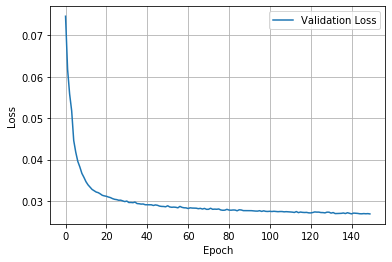

In [37]:
# Plot losses
plt.close('all')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

### Training with Random Search

Here we will search the best hyperparameters tuning the learning process through a Random Search. In particular we will search for the best values of `lr`,`weight_decay` and `dropout`. The following class has to generate combinations of those parameters, sampling them from their correspondent distribution.

In [24]:
# Class that generates random combinations of the 
# parameters to perform the random search
class Param_generator():
    
    def __init__(self, drop_limits, lr_limits, L2_limits):
        
        self.drop_min = drop_limits[0]
        self.drop_max = drop_limits[1]
        self.lr_min_exp = lr_limits[0]
        self.lr_max_exp = lr_limits[1]
        self.L2_min_exp = L2_limits[0]
        self.L2_max_exp = L2_limits[1]    
        
        
    def gen_values(self, n_combins):
        
        drop_vals = np.random.uniform(self.drop_min, self.drop_max, n_combins)
        lr_vals = 10**(np.random.uniform(self.lr_min_exp, self.lr_max_exp, n_combins))
        L2_vals = 10**(np.random.uniform(self.L2_min_exp, self.L2_max_exp, n_combins))              
        
        combins_list = [ (drop_vals[i], lr_vals[i], L2_vals[i]) for i in range(n_combins)]
        return combins_list

    
# Initialize parameters generator giving the bounds of each distribution, the optims and their probs
pars_generator = Param_generator( [0,0.6], [-4,-1], [-6,-2] )

Here we will perform the Random Search by defining and training a network for each combination of parameters: The best one will be kept for the following points of the exercise.

In [20]:
# Define a loss function
loss_fn = torch.nn.MSELoss()

# generate combinations of paramereters and prepare scores array
params_combinations = pars_generator.gen_values(50)
all_scores = np.zeros(len(params_combinations))

# other params for training
encoded_space_dim = 4
num_epochs = 80
best_score = 1000000 #arbitrary big number



####### RANDOM SEARCH #######
print('Starting Random Search process')
start = time.time()

for i in range(len(params_combination)):
    
    # Extact params
    dropout, lr, L2_decay = params_combination[i]
    
    # Generate the network
    net = Autoencoder(encoded_space_dim=encoded_space_dim, dropout)
    net.to(device)

    # Define an optimizer
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2_decay)

    ### Train the model
    for epoch in range(num_epochs):
        net.train_epoch(dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim, log=False) 

    # Compute final validation loss
    test_loss = net.test_epoch(dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim) 
    
    # Print and store final loss value
    all_scores[i] = test_loss
    print('\nNetwork trained with: Dropout =',dropout,', lr =',lr,', L2_decay =',L2_decay)
    print('Final loss value: \t', test_loss)
    
    # If this is the best score, keep model as the best one
    if test_loss < best_score:
        best_net = net
        best_score = test_loss
        

    
# Print time needed to complete Random Search
finish = time.time()
print('\n\n Random Search process took', int(finish-start), 'seconds')

# Sort scores from best to worst and the combinations accordingly
sorted_scores, sorted_params = zip(*sorted(zip(all_scores, params_combinations),reverse=True))
print('\n\nBest combination of training params is', sorted_params[0])

# Store Best Network weights       
torch.save(net.state_dict(), 'best_net_params_4.pth')

# Save the sorted scores and params combinations in 2 files
with open('sorted_scores.dat', 'w') as f:
    for item in sorted_scores:
        f.write("%s\n" % item)
        
with open('sorted_params.dat', 'w') as f:
    for item in sorted_params:
        f.write("%s,%s,%s\n" % item)

EPOCH 1/10


	 VALIDATION - EPOCH 1/10 - loss: 0.048750


EPOCH 2/10


	 VALIDATION - EPOCH 2/10 - loss: 0.048080


EPOCH 3/10


	 VALIDATION - EPOCH 3/10 - loss: 0.047526


EPOCH 4/10


	 VALIDATION - EPOCH 4/10 - loss: 0.046964


EPOCH 5/10


	 VALIDATION - EPOCH 5/10 - loss: 0.046363


EPOCH 6/10


	 VALIDATION - EPOCH 6/10 - loss: 0.045789


EPOCH 7/10


	 VALIDATION - EPOCH 7/10 - loss: 0.045215


EPOCH 8/10


	 VALIDATION - EPOCH 8/10 - loss: 0.044563


EPOCH 9/10


	 VALIDATION - EPOCH 9/10 - loss: 0.044159


EPOCH 10/10


	 VALIDATION - EPOCH 10/10 - loss: 0.043747




In [ ]:
# If training was done in the past, you can load the trained network
net.load_state_dict(torch.load('best_net_params_4.pth', map_location='cpu'))

### Performance for different sizes of the hidden layer
Now we will use the `best_params` find before to train networks with different sizes of the hidden layer (we will go from 1 to 10) to check how this will impact the performances.

In [ ]:
# Take best training params 
dropout = 0.4
lr = 0.001
L2_decay = 0.00005

loss_fn = torch.nn.MSELoss()
num_epochs = 100

# Prepare array that will contain the final losses for each architecture 
final_losses = np.zeros(10)


for hidden_size in range(1,11):
    
    # Generate the network
    net = Autoencoder(encoded_space_dim=hidden_size, dropout)
    net.to(device)

    # Define an optimizer
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2_decay)

    ### Train the model
    for epoch in range(num_epochs):
        net.train_epoch(dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim, log=False) 

    # Compute final validation loss
    test_loss = net.test_epoch(dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim) 
    final_losses[hidden_size-1] = test_loss 
    print('Network with',hidden_size,'hidden neurons : ',test_loss)

In [ ]:
# Plot losses
plt.close('all')
plt.plot(final_losses, label='Final loss values')
plt.xlabel('Size of the hidden layer')
plt.ylabel('Loss')
#plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

## Testing tools
### Plot comparison between original and reconstructed sample

In [ ]:
testing_tools.plot_comparison(net, test_dataset)
# check if it can be improved (single image)

### Encoded space visualization

In [ ]:
# function to get the encoded representation of some input dataset
def get_enc_representation(dataset, net):
    encoded_samples = []
    
    for sample in tqdm(dataset):
        img = sample[0].unsqueeze(0)
        label = sample[1]
        
        # Encode image
        net.eval()
        with torch.no_grad():
            encoded_img  = net.encode(img)
            
        # Append to list
        encoded_samples.append((encoded_img.flatten().numpy(), label))
    
    return encoded_samples  


# Function to plot the first two variables of the encoded 
# representation of the encoded samples given as argument
def plot_enc_representation(encoded_samples, n_samples_to_plot = 1000):
    
    # define colors associated to each label
    color_map = { 0: '#1f77b4',
                  1: '#ff7f0e',
                  2: '#2ca02c',
                  3: '#d62728',
                  4: '#9467bd',
                  5: '#8c564b',
                  6: '#e377c2',
                  7: '#7f7f7f',
                  8: '#bcbd22',
                  9: '#17becf' }
    
    ### Visualize encoded space
    encoded_samples_reduced = random.sample(encoded_samples, n_samples_to_plot)
    plt.figure(figsize=(8,6))
    for enc_sample, label in tqdm(encoded_samples_reduced):
        plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
    plt.grid(True)
    plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
    plt.tight_layout()
    plt.show()
    
    return

In [ ]:
# Use the functions above to plot the encoded representation
# of the test dataset

enc_test_data = get_enc_representation(test_dataset, net)
plot_enc_representation(enc_test_data)

### Decode custom sample

In [ ]:
def generate_from_encoded_sample(enc_sample, net):
    
    # Decode the sample to produce the image
    net.eval()
    with torch.no_grad():
        encoded_value = torch.tensor(enc_sample).float().unsqueeze(0)
        new_img  = net.decode(encoded_value)

    # plot the generated image
    plt.figure(figsize=(12,10))
    plt.imshow(new_img.squeeze().numpy(), cmap='gist_gray')
    plt.show()
    
    return

In [ ]:
generate_from_encoded_sample([8.0, -12.0], net)